In [1]:
import warnings
warnings.filterwarnings("ignore")
import os.path
import numpy as np
import pandas as pd
from scipy import stats
import tensorflow as tf
from datetime import datetime
from sklearn.preprocessing import scale
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, LeaveOneOut

import seaborn as sns
import matplotlib.pyplot as plt
from aggmap import AggMap, AggMapNet, show, loadmap, AggMapNet_DP

In [2]:
def imshow(x_arr,  ax, mode = 'dark',  color_list = ['#1300ff','#ff0c00','#25ff00', '#d000ff','#e2ff00', '#00fff6', \
                                                     '#ff8800', '#fccde5','#178b66', '#8a0075'], x_max = 255, vmin = -1, vmax = 1, cbar = True):
    
    
    assert x_arr.ndim == 3, 'input must be 3d array!'
    w, h, c = x_arr.shape
    assert len(color_list)+1 >= c, 'length of the color list should equal or larger than channel numbers'
    
    x = x_arr.copy()
    x[x == 0] = 'nan'

    xxx = x_arr.sum(axis=-1)
    xxx[xxx != 0] = 'nan'

    if mode == 'dark':
        cmaps = [sns.dark_palette(color, n_colors =  50, reverse=False) for color in color_list]

    else:
        cmaps = [sns.light_palette(color, n_colors =  50, reverse=False) for color in color_list]
    
    sns.heatmap(x_arr.sum(axis=-1), ax = ax, cmap = sns.color_palette("rainbow", 50), cbar = cbar)
    for i in range(c-1):
        data = x[:,:,i+1]/x_max
        sns.heatmap(data, cmap = cmaps[i], vmin = vmin, vmax = vmax, \
                    yticklabels=False, xticklabels=False, cbar=False, ax=ax) # linewidths=0.005, linecolor = '0.9'

In [3]:
#Feature Importance
file = "Bortezomib_PD-R_response_simp-importance_channels(9)_0"

df_imp = pd.read_csv(f"./5_feature_importance/{file}.csv", index_col = 0)
df_imp.sort_values("simply_importance_class_1", ascending = False).iloc[:30]

,x,y,Subtypes,colors,simply_importance_class_0,simply_importance_class_1
MRM1,88,53,cluster_05,#00fff6,13.170760,13.170580
UBE3C,97,56,cluster_06,#0074ff,12.466293,12.466243
MED28,100,58,cluster_07,#2500ff,11.244588,11.244515
GLT8D1,97,61,cluster_07,#2500ff,10.476943,10.476808
MAPKAP1,104,54,cluster_06,#0074ff,9.642679,9.642705
B4GALT4,92,57,cluster_07,#2500ff,9.558852,9.558789
SLAMF7,89,55,cluster_07,#2500ff,9.087760,9.087767
SLC35A5,98,59,cluster_06,#0074ff,8.778832,8.778899
FAIM,95,50,cluster_06,#0074ff,8.288033,8.288011
FAM168B,98,61,cluster_07,#2500ff,8.188896,8.188856


In [4]:
#Feature Importance
file_11 = "Infliximab-1(train)-Infliximab-2(test)_simp-importance_channels(9)_0"
file_12 = "Infliximab-2(train)-Infliximab-1(test)_simp-importance_channels(9)_0"
file_21 = "KT-1(train)-KT-2(test)_simp-importance_channels(7)_0"
file_22 = "KT-2(train)-KT-1(test)_simp-importance_channels(7)_0"

df_imp11 = pd.read_csv(f"./5_feature_importance/{file_11}.csv", index_col = 0)
df_imp12 = pd.read_csv(f"./5_feature_importance/{file_12}.csv", index_col = 0)
df_imp21 = pd.read_csv(f"./5_feature_importance/{file_21}.csv", index_col = 0)
df_imp22 = pd.read_csv(f"./5_feature_importance/{file_22}.csv", index_col = 0)

df_imp11.sort_values("simply_importance_class_1", ascending = False).iloc[:30]

,x,y,Subtypes,colors,simply_importance_class_0,simply_importance_class_1
SLC26A4-AS1,1,134,cluster_09,#ff00ac,23.974470,23.974529
KLHL23,3,138,cluster_08,#b900ff,17.623530,17.623573
DNAL4,7,137,cluster_08,#b900ff,11.515654,11.515632
HOXD13,0,136,cluster_09,#ff00ac,11.488718,11.488706
RP1-193H18.2,1,140,cluster_07,#2500ff,11.261457,11.261408
SPINK1,5,140,cluster_06,#0074ff,10.748780,10.748879
SEMG1,75,144,cluster_05,#00fff6,10.583129,10.583217
ARHGAP26,82,141,cluster_06,#0074ff,10.218768,10.218736
F3,84,142,cluster_06,#0074ff,10.143882,10.143976
SERPINB1,77,143,cluster_06,#0074ff,10.039074,10.039032


In [5]:
df_imp1 = pd.DataFrame()
for i in ['CR', 'PR', 'MR', 'PD']:
    one_imp = pd.read_csv(f"./5_feature_importance/Bortezomib+PS341+PD-R_response-{i}_simp-importance_channels(9)_0.csv", index_col = 0, header = 0)
    one_imp = one_imp.mean(axis = 1)
    one_imp.rename(i, inplace = True)
    df_imp1 = pd.concat([df_imp1, one_imp], axis = 1)
df_imp1

,CR,PR,MR,PD
ITCH,-0.333047,-0.335943,-0.326719,-0.378956
LOC100127886,-0.321201,-0.246666,-0.257250,-0.273894
PLEKHA2,-0.159105,-0.302747,-0.388124,-0.185887
GRIA2,-0.395648,-0.333680,-0.361867,-0.449826
USP25,-0.402528,-0.223692,-0.336266,-0.288106
...,...,...,...,...
NaN-12651,-0.397113,-0.351565,-0.359525,-0.493173
NaN-12652,-0.397113,-0.351565,-0.359525,-0.493173
NaN-12653,-0.397113,-0.351565,-0.359525,-0.493173
NaN-12654,-0.397113,-0.351565,-0.359525,-0.493173


In [6]:
df_imp2 = pd.DataFrame()
for i in ['CR', 'PR', 'MR', 'PD']:
    one_imp = pd.read_csv(f"./5_feature_importance/Bortezomib+PS341+NR-R_response-{i}_simp-importance_channels(5)_0.csv", index_col = 0, header = 0)
    one_imp = one_imp.mean(axis = 1)
    one_imp.rename(i, inplace = True)
    df_imp2 = pd.concat([df_imp2, one_imp], axis = 1)
df_imp2

,CR,PR,MR,PD
ITCH,-0.537512,-0.467368,-0.471163,0.206828
LOC100127886,-0.420022,-0.453139,-0.508421,0.137195
PLEKHA2,-0.243720,-0.276151,-0.292732,0.045044
GRIA2,-0.333571,-0.365488,-0.364812,-0.172231
USP25,-0.372230,-0.477605,-0.501272,0.115406
...,...,...,...,...
NaN-12651,-0.297625,-0.317147,-0.349083,-0.306250
NaN-12652,-0.297625,-0.317147,-0.349083,-0.306250
NaN-12653,-0.297625,-0.317147,-0.349083,-0.306250
NaN-12654,-0.297625,-0.317147,-0.349083,-0.306250


In [7]:
#Value-based channel
def return_array(df_imp, x):
    df_imp = df_imp.copy()
    df_nd = np.array(df_imp[x]).reshape(int(np.ceil(np.sqrt(len(df_imp)))),-1,1)
    figure_mp = df_nd.copy()

    h, w, c = figure_mp.shape
    new_array = np.zeros((h, w, 4), dtype = np.float32)
    new_mp = figure_mp.sum(axis = -1).reshape(h, w)

#     l = 0
#     for i in [30, 75, 90]:
#         exec("per_{} = np.percentile(new_mp, {})".format(l,i))
#         l += 1
    per_0 = np.sort(new_mp, axis = None)[-200]
    per_1 = np.sort(new_mp, axis = None)[-100]
    per_2 = np.sort(new_mp, axis = None)[-30]

    for i in range(h):
        for j in range(w):
            a = new_mp[i,j]
            if a <= per_0:
                new_array[i,j,0] = a
            elif per_0 < a <= per_1:
                new_array[i,j,1] = a
            elif per_1 < a <= per_2:
                new_array[i,j,2] = a
            else:
                new_array[i,j,3] = a
    
    return new_array

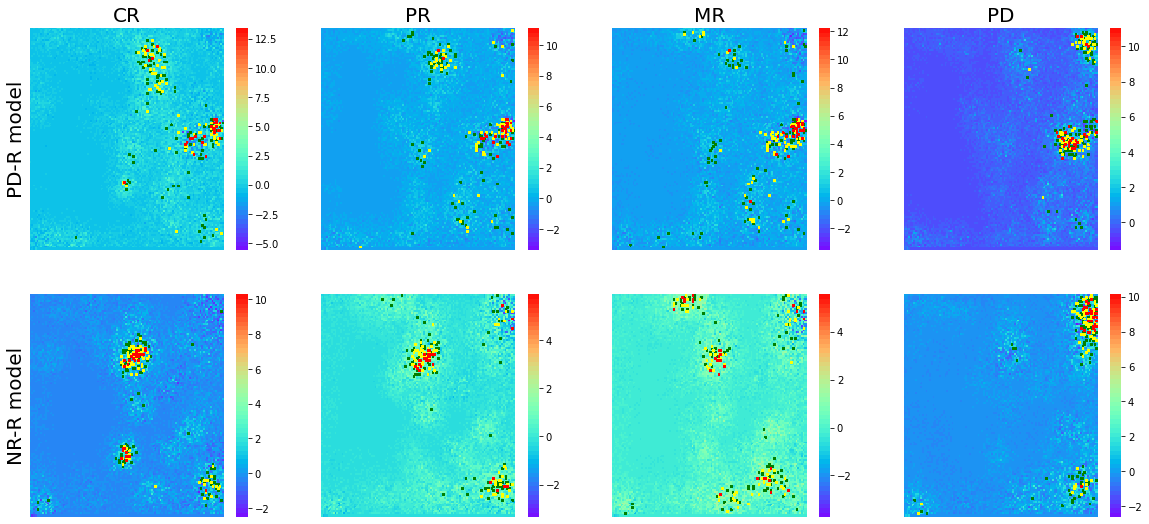

In [8]:
k = 0
fv_max1 = np.nanpercentile(df_imp1, 95)
fv_min1 = np.nanpercentile(df_imp1, 5)
fv_max2 = np.nanpercentile(df_imp2, 95)
fv_min2 = np.nanpercentile(df_imp2, 5)

cmax = max(fv_max1, fv_max2)
cmin = min(fv_min1, fv_min2)
c_list = ['green','yellow', 'red']

fig_imp, axes_imp = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 9), sharex = True, sharey = True)
for i in ["CR", "PR", "MR", "PD"]:
    new_a1 = return_array(df_imp1, i)
    new_a2 = return_array(df_imp2, i)
    imshow(new_a1, axes_imp[0,k], mode="dark", color_list = c_list, x_max = 1, vmin = fv_min1, vmax = fv_max1)
    imshow(new_a2, axes_imp[1,k], mode="dark", color_list = c_list, x_max = 1, vmin = fv_min2, vmax = fv_max2)
    axes_imp[0,k].set_title(i, fontsize=20)
    
    k += 1

axes_imp[0,0].set_ylabel("PD-R model",fontsize=20)
axes_imp[1,0].set_ylabel("NR-R model",fontsize=20)
fig_imp.show()

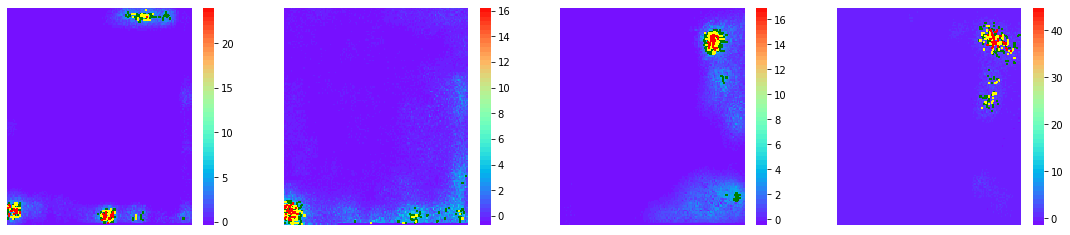

In [14]:
k = 0
fv_max11 = np.nanpercentile(df_imp11.simply_importance_class_1, 95)
fv_min11 = np.nanpercentile(df_imp11.simply_importance_class_1, 5)
fv_max12 = np.nanpercentile(df_imp12.simply_importance_class_1, 95)
fv_min12 = np.nanpercentile(df_imp12.simply_importance_class_1, 5)
fv_max21 = np.nanpercentile(df_imp21.simply_importance_class_1, 95)
fv_min21 = np.nanpercentile(df_imp21.simply_importance_class_1, 5)
fv_max22 = np.nanpercentile(df_imp22.simply_importance_class_1, 95)
fv_min22 = np.nanpercentile(df_imp22.simply_importance_class_1, 5)

cmin = min(fv_min11, fv_min12, fv_min21, fv_min22)
cmax = max(fv_max11, fv_max12, fv_max21, fv_max22)
c_list = ['green','yellow', 'red']

fig_imp, axes_imp = plt.subplots(nrows = 1, ncols = 4, figsize=(19, 4), sharex = True, sharey = True)
for i in [df_imp11, df_imp12, df_imp21, df_imp22]:
    new_a = return_array(i, "simply_importance_class_1")  
    imshow(new_a, axes_imp[k], mode="dark", color_list = c_list, x_max = 1, vmin = cmin, vmax = cmax)
    
    k += 1

fig_imp.show()

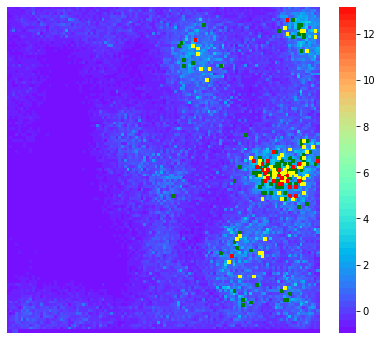

In [5]:
fv_max1 = np.nanpercentile(df_imp.simply_importance_class_1, 95)
fv_min1 = np.nanpercentile(df_imp.simply_importance_class_1, 5)
c_list = ['green', 'yellow', 'red']

fig_imp, axes_imp = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 6), sharex = True, sharey = True)
new_a1 = return_array(df_imp, "simply_importance_class_1")
imshow(new_a1, axes_imp, mode="dark", color_list = c_list, x_max = 1, vmin = fv_min1, vmax = fv_max1)

#axes_imp.set_title(i)
# axes_imp[0,0].set_ylabel("PD-R model")#,fontsize=40)
# axes_imp[1,0].set_ylabel("NR-R model")#,fontsize=40)
fig_imp.show()

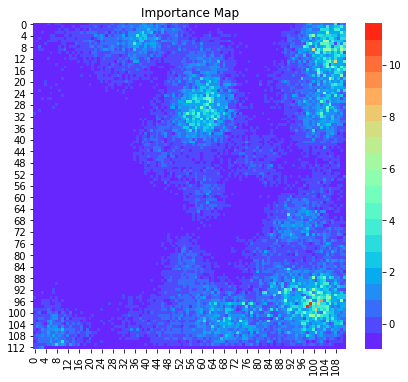

In [8]:
#Feature Importance Map
k = 0
fv_max1 = np.nanpercentile(df_imp["simply_importance_class_1"], 95)
fv_min1 = np.nanpercentile(df_imp["simply_importance_class_1"], 5)

c_list = ["darkgreen","silver","darkgrey","deeppink"]

df_nd = np.array(df_imp.simply_importance_class_1).reshape(int(np.ceil(np.sqrt(len(df_imp)))),-1)
fig_imp, axes_imp = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 6), sharex = True, sharey = True)

sns.heatmap(df_nd, ax = axes_imp, cmap = sns.color_palette("rainbow", 20))  #RdBu_r
#sns.heatmap(df_nd, ax = axes_imp[1], cmap = "RdBu_r", mask = df_nd < 0)

axes_imp.set_title("Importance Map")
#axes_imp[1].set_title("Genes of Potential Importance > 0")
#fig_imp.suptitle("Genes' Importance Map")
fig_imp.show()

In [9]:
fig_imp.savefig("/raid/mobu/6_figure/{}.jpg".format("0_Bor-imp"))